In [16]:
import os
import sys
import torch
from pathlib import Path
import yaml
from torch_geometric.datasets import WikiCS
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
from IPython.display import display, Markdown

# Uczenie reprezentacji
część wykonana na uczenie reprezentacji

In [2]:
sys.path.append(str(Path(os.getcwd()).resolve().parent))
from src.load_data import get_statistics

In [5]:
def class_histogram(nd_features):
    fig, ax = plt.subplots()
    sns.histplot(nd_features.y, bins=len(torch.unique(nd_features.y)), discrete=True)
    plt.xticks(torch.unique(nd_features.y))
    ax.set_xticklabels(torch.unique(nd_features.y).numpy())
    plt.title("Class histogram")
    plt.show()

## Dane wejściowe
- Zbiór WikiCS
- Graf prac naukowych z 10 gałęzi informatyki
- **Cechy wierchołków:** średnia z wektorów osadzeń tesktu pracy
- **Krawędzie grafu:** cytowania

In [4]:
dataset_path = Path(os.getcwd()).resolve().parent / "data" / "WikiCS"
dataset = WikiCS(root=dataset_path, is_undirected=True)
original_data = dataset[0]
get_statistics(original_data)

{'num_nodes': 11701,
 'num_edges': 215863,
 'attr_dim': 300,
 'num_classes': 10,
 'is_directed': False,
 'graph_density': 0.3153547399338358}

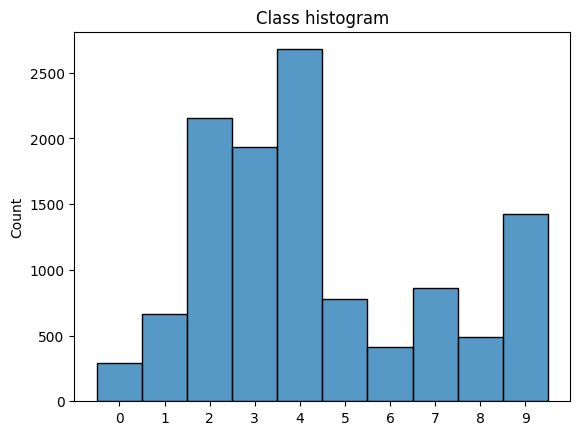

In [6]:
class_histogram(original_data)

- **Zastosowanie reprezentacji:** klasteryzacja, klasyfikacja
- **Hipoteza:** Osadzenia wyprodukowane przez enkoder uczony metodą GCA pozwalają na lepszą klasteryzację niż tylko w oparciu o cechy wierzchołków
- **Hipoteza:** MLP w funcji straty GCA nie jest potrzebne

## GCA
- **Graph Contrastive Learning with Adaptive Augmentation** [(2021, Zhu et. al.)](https://arxiv.org/abs/2010.14945)
- Metoda zainspirowana SimCLR
- Stosuje augmentacje: usuwanie krawędzi, maskowanie cech
- Prawdopobieństwo usunięcia krawędzi lub zamaskowania cechy jest odwrotnie propocjonalne do "ważności" krawędzi/cechy.
- Wykorzystuje funkcję straty prawie jak SimCLR (używa dodatkowego MLP w funcji straty)

In [31]:
def pca_visaulise(nd_features, nd_embeddings, frac: float = 0.2, seed: int = 0):
    f_pca = PCA(n_components=2)
    f_2d = StandardScaler().fit_transform(nd_features.x)
    f_2d = f_pca.fit_transform(f_2d)

    e_pca = PCA(n_components=2)
    e_2d = StandardScaler().fit_transform(nd_embeddings)
    e_2d = e_pca.fit_transform(e_2d)

    if not frac is None:
        rng = np.random.default_rng(seed=seed)
        indexes = rng.choice(nd_embeddings.shape[0], size=int(nd_embeddings.shape[0] * frac), replace=False)

        df_f_pca = pd.DataFrame({'PCA1': f_2d[:, 0][indexes], 'PCA2': f_2d[:, 1][indexes], 'label': nd_features.y[indexes]})
        df_e_pca = pd.DataFrame({'PCA1': e_2d[:, 0][indexes], 'PCA2': e_2d[:, 1][indexes], 'label': nd_features.y[indexes]})
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_f_pca, palette='tab10', alpha=0.8, ax=ax[0])
        ax[0].set_title(f"Node features (explained variance: {f_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
        sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_e_pca, palette='tab10', alpha=0.8, ax=ax[1])
        ax[1].set_title(f"Node embedings (explained variance: {e_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
        fig.tight_layout()
        plt.show()
    else:
        df_f_pca = pd.DataFrame({'PCA1': f_2d[:, 0], 'PCA2': f_2d[:, 1], 'label': nd_features.y})
        df_e_pca = pd.DataFrame({'PCA1': e_2d[:, 0], 'PCA2': e_2d[:, 1], 'label': nd_features.y})
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_f_pca, palette='tab10', alpha=0.8, ax=ax[0])
        ax[0].set_title(f"Node features (explained variance: {f_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
        sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_e_pca, palette='tab10', alpha=0.8, ax=ax[1])
        ax[1].set_title(f"Node embedings (explained variance: {e_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
        fig.tight_layout()
        plt.show()

def run_test_for_one_split(xs, ys, train_mask, test_mask):
    tester = Pipeline([
        ('scaler', StandardScaler()), 
        ('estimator', LogisticRegression(max_iter=1000))
    ])
    tester.fit(xs[train_mask], ys[train_mask])
    y_train_pred = tester.predict(xs[train_mask])
    y_test_pred = tester.predict(xs[test_mask])
    return {
        'train_acc': accuracy_score(y_true=ys[train_mask], y_pred=y_train_pred),
        'test_acc': accuracy_score(y_true=ys[test_mask], y_pred=y_test_pred),
        'train_auc': roc_auc_score(y_true=ys[train_mask], y_score=tester.predict_proba(xs[train_mask]), multi_class='ovr'),
        'test_auc': roc_auc_score(y_true=ys[test_mask], y_score=tester.predict_proba(xs[test_mask]), multi_class='ovr'),
    }

def classification_test(nd_features, nd_embedings):
    results_features = []
    results_embedings = []
    for split_id in range(20):
        results_features.append(run_test_for_one_split(nd_features.x, nd_features.y, nd_features.train_mask[:, split_id], nd_features.test_mask))
        results_embedings.append(run_test_for_one_split(nd_embedings, nd_features.y, nd_features.train_mask[:, split_id], nd_features.test_mask))

    df_features = pd.DataFrame(results_features)
    df_embedings = pd.DataFrame(results_embedings)
    return (df_features, df_embedings)

def full_experiment(original_data, node_embeddings):
    pca_visaulise(original_data, node_embeddings, frac=None)
    df_features, df_embeddings = classification_test(original_data, node_embeddings)
    df_features['type'] = 'features'
    df_embeddings['type'] = 'embeddings'
    df = pd.concat([df_features, df_embeddings])
    return df
    
def pp_print(df_, cols = ['train_acc', 'test_acc', 'train_auc', 'test_auc']):
    df = df_.groupby('type').agg(['mean', 'std'])[cols].copy()
    for col in cols:
        df[(col, 'mean±std')] = df[(col, 'mean')].round(3).astype(str) + ' ± ' + df[(col, 'std')].round(3).astype(str)

    result = df[[(cols[i], 'mean±std') for i in range(len(cols))]]
    result.columns = cols
    result.reset_index(inplace=True)
    display(Markdown(df[[(cols[i], 'mean±std') for i in range(len(cols))]].to_markdown()))

In [32]:
def load_execute(original_data, embedding_name: str):
    embedings_path = Path(os.getcwd()).resolve().parent / "data" / "embeddings" / embedding_name
    with open(embedings_path, 'rb') as f:
        ebs = torch.load(f).numpy()
        
    display(Markdown(f"**{embedding_name}**"))
    df = full_experiment(original_data, ebs)
    display(Markdown(f"**{embedding_name}**"))
    pp_print(df)
    return df

In [33]:
dims = [4, 16, 64, 128, 256]
gate_embeddings = [f"node_embeddings_gca_gate_{d}_1.0.pt" for d in dims]
gcn_embeddings = [f"node_embeddings_gca_gcn_{d}_1.0.pt" for d in dims]

W tej części wyuczona reprezentacja jest sprawdzana na zadaniu klasyfikacji w celu porówania z wynikami w pracy GCA. Klasyfikacja jest wykonywana przy użyciu modelu regresji logistycznej na 20 splitach danych w zbiorze WikiCS.

Testy przeprowadzone dla embeddingów wyprodukowanych koderm opartym o GCNConv i GATEConv.

**node_embeddings_gca_gate_4_1.0.pt**

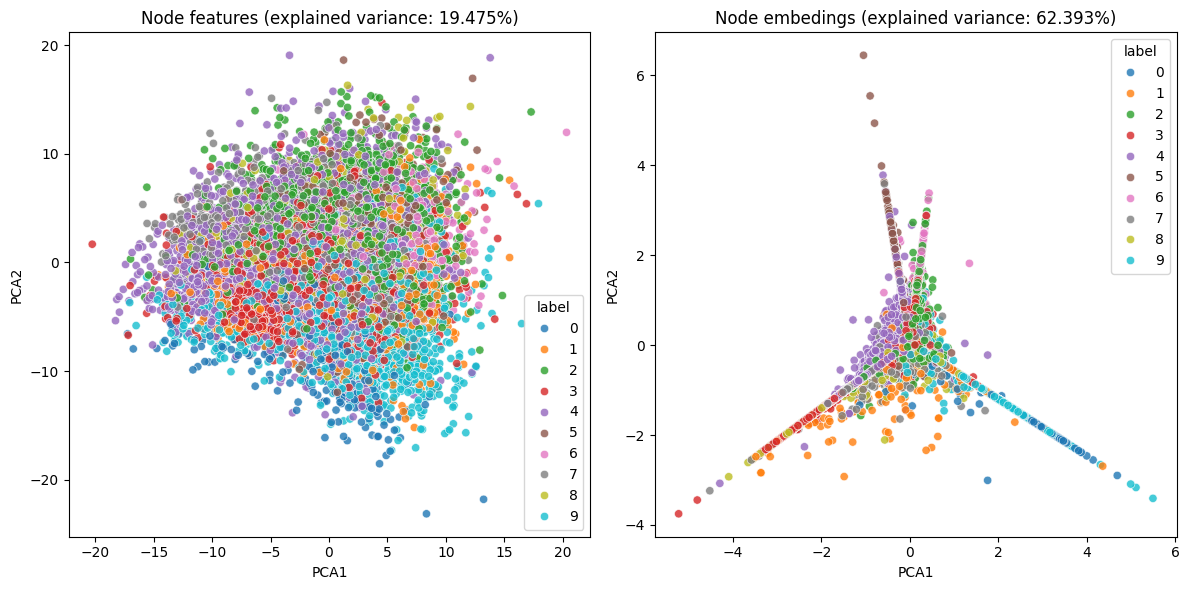

**node_embeddings_gca_gate_4_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.507 ± 0.022               | 0.495 ± 0.012              | 0.856 ± 0.007               | 0.84 ± 0.003               |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gate_16_1.0.pt**

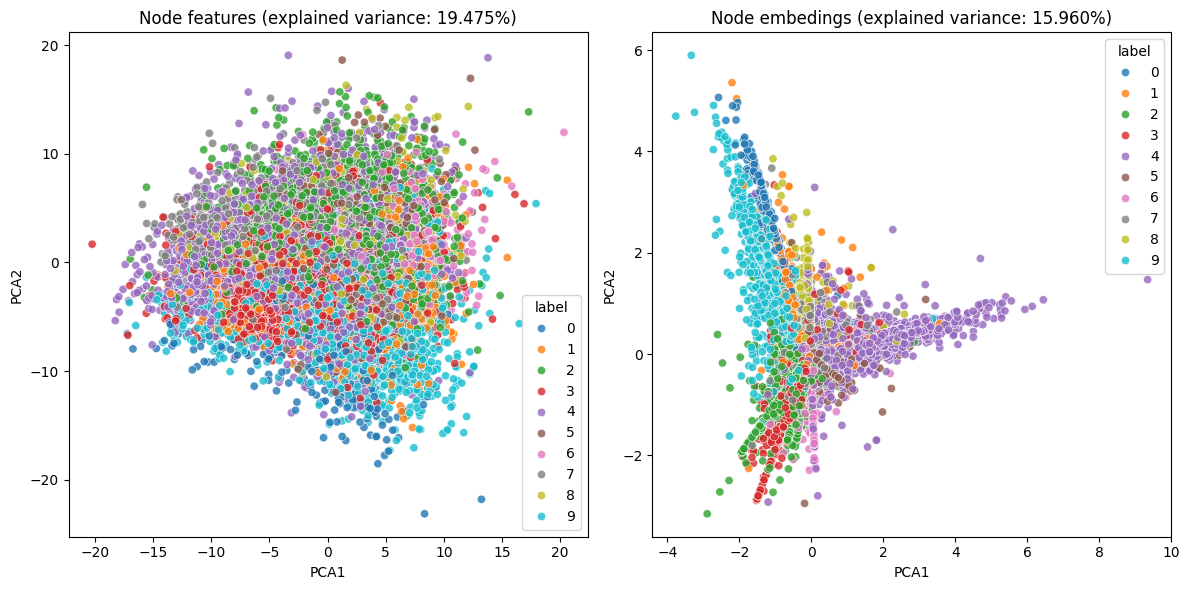

**node_embeddings_gca_gate_16_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.767 ± 0.018               | 0.74 ± 0.004               | 0.97 ± 0.003                | 0.943 ± 0.002              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gate_64_1.0.pt**

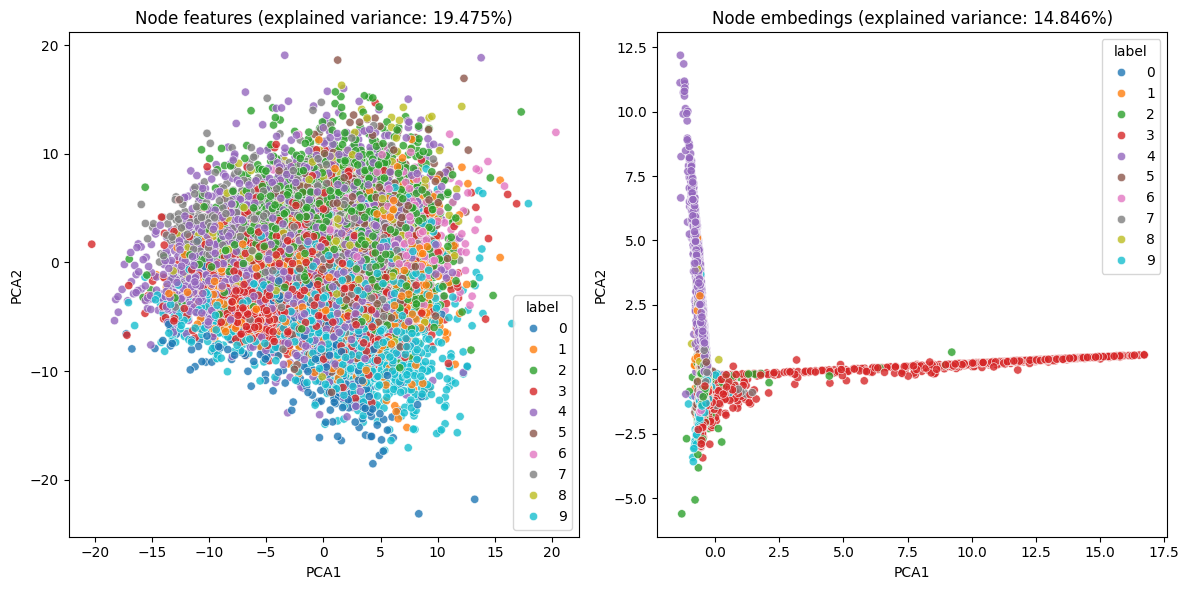

**node_embeddings_gca_gate_64_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.832 ± 0.013               | 0.754 ± 0.006              | 0.986 ± 0.002               | 0.941 ± 0.004              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gate_128_1.0.pt**

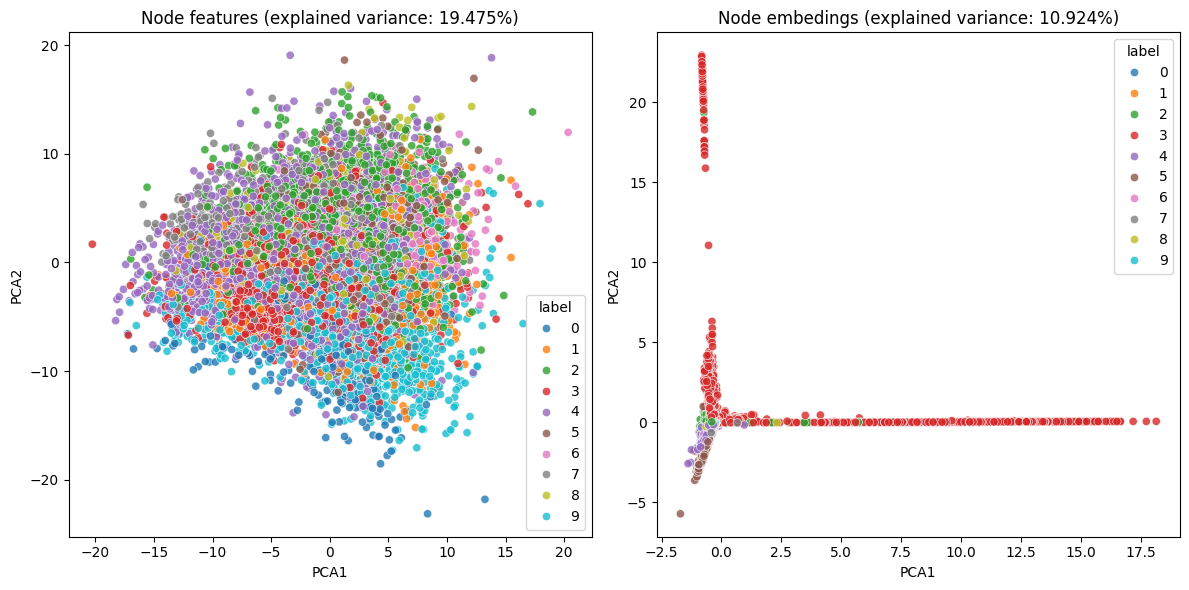

**node_embeddings_gca_gate_128_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.854 ± 0.017               | 0.754 ± 0.007              | 0.99 ± 0.002                | 0.937 ± 0.004              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gate_256_1.0.pt**

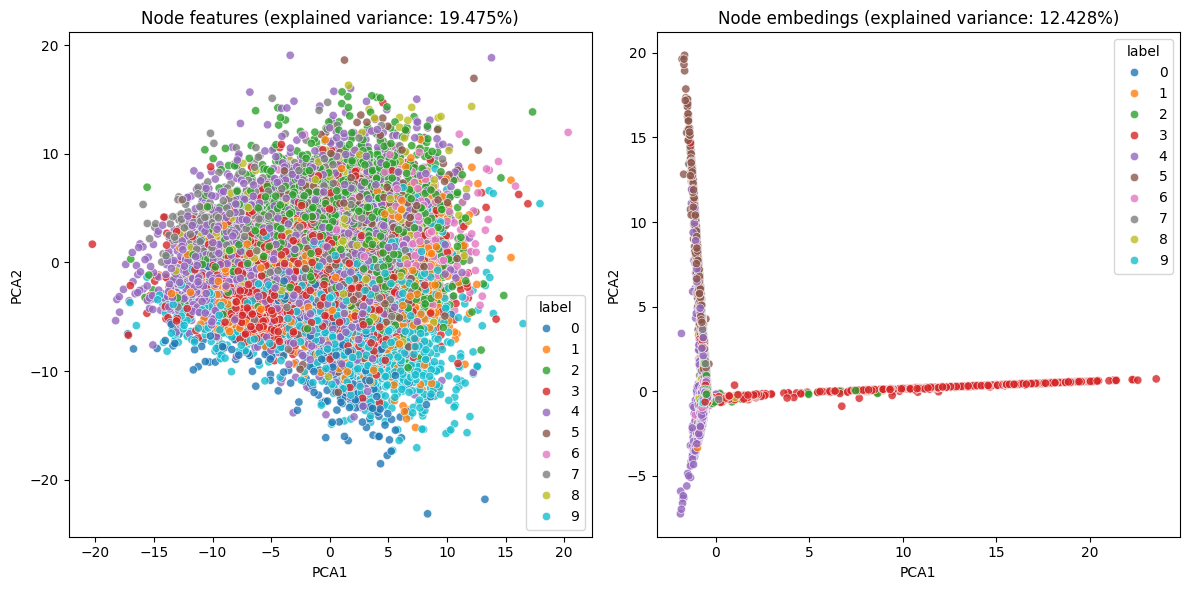

**node_embeddings_gca_gate_256_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.872 ± 0.019               | 0.747 ± 0.01               | 0.993 ± 0.002               | 0.936 ± 0.006              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

In [34]:
gate_results = []
for e in gate_embeddings:
    df = load_execute(original_data, e)
    gate_results.append(df)

**node_embeddings_gca_gcn_4_1.0.pt**

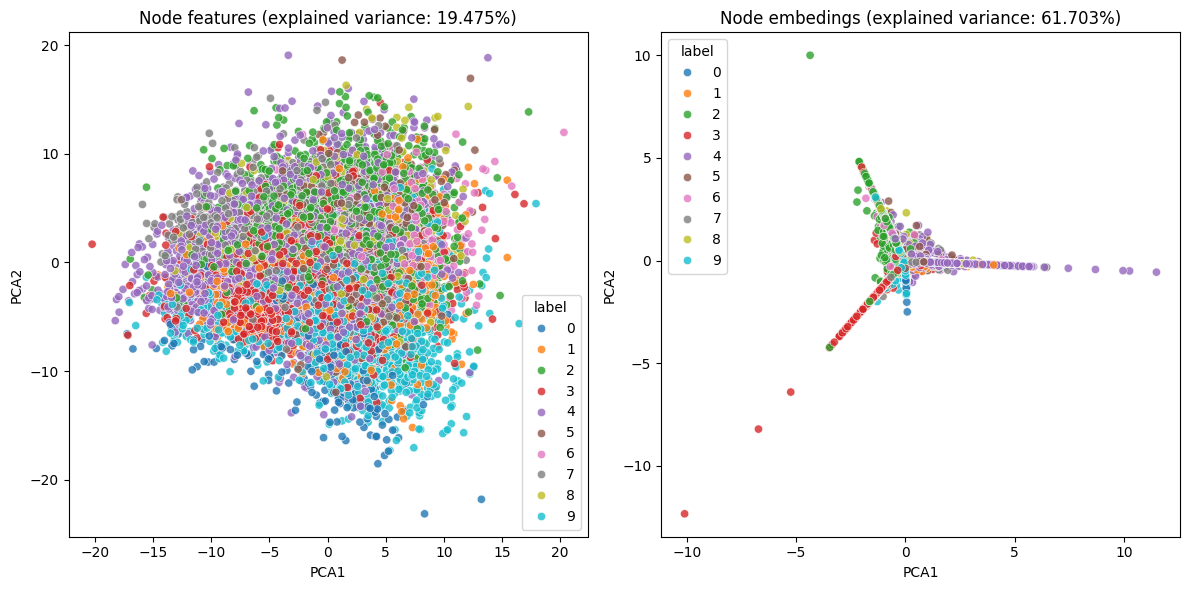

**node_embeddings_gca_gcn_4_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.559 ± 0.018               | 0.56 ± 0.003               | 0.862 ± 0.007               | 0.843 ± 0.004              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gcn_16_1.0.pt**

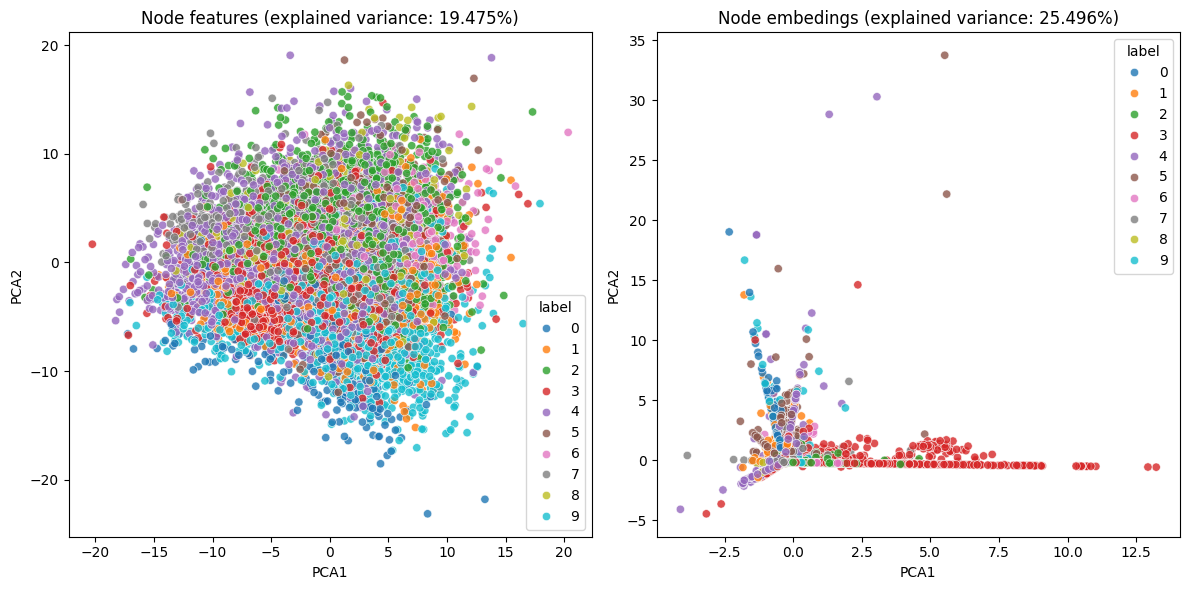

**node_embeddings_gca_gcn_16_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.512 ± 0.021               | 0.494 ± 0.012              | 0.861 ± 0.011               | 0.841 ± 0.005              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gcn_64_1.0.pt**

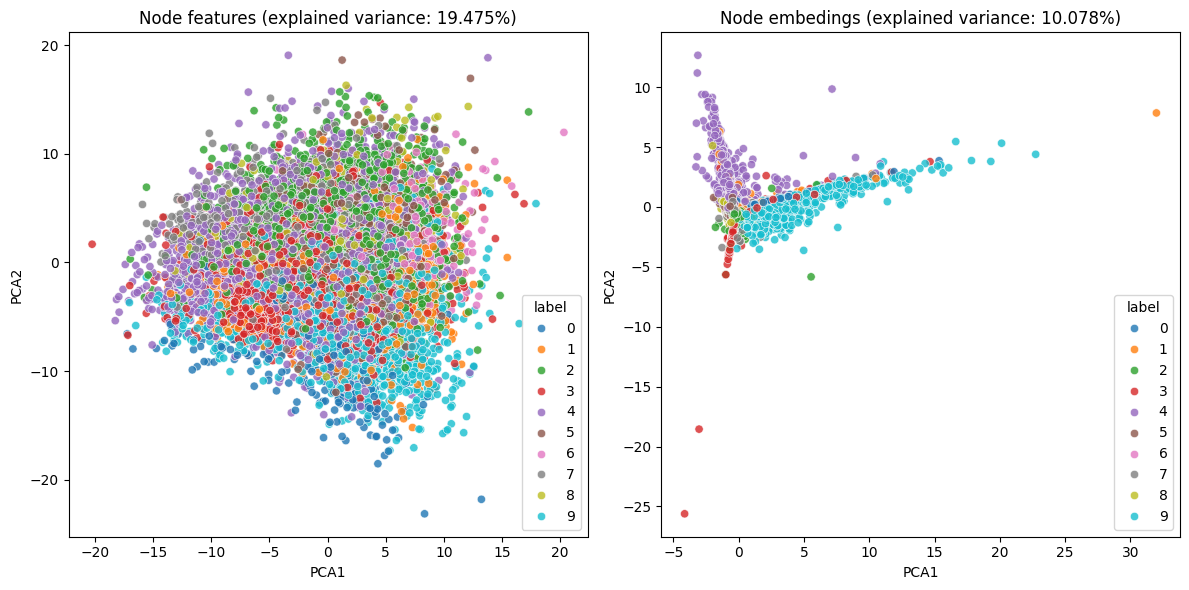

**node_embeddings_gca_gcn_64_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.815 ± 0.015               | 0.752 ± 0.007              | 0.984 ± 0.002               | 0.943 ± 0.003              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gcn_128_1.0.pt**

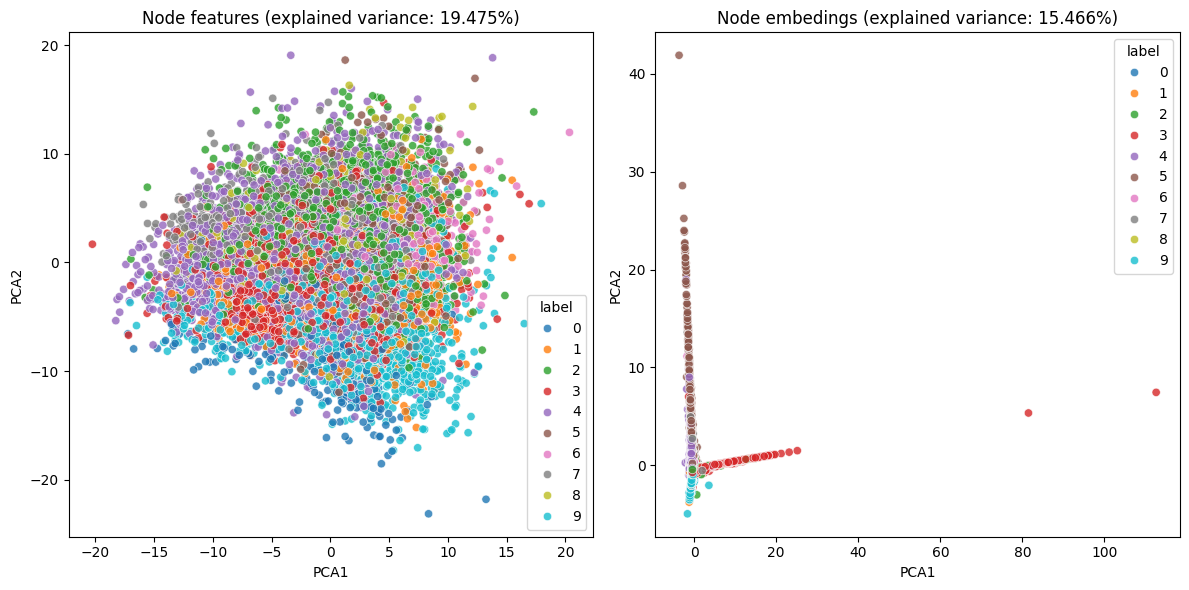

**node_embeddings_gca_gcn_128_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.876 ± 0.015               | 0.766 ± 0.006              | 0.993 ± 0.001               | 0.948 ± 0.005              |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

**node_embeddings_gca_gcn_256_1.0.pt**

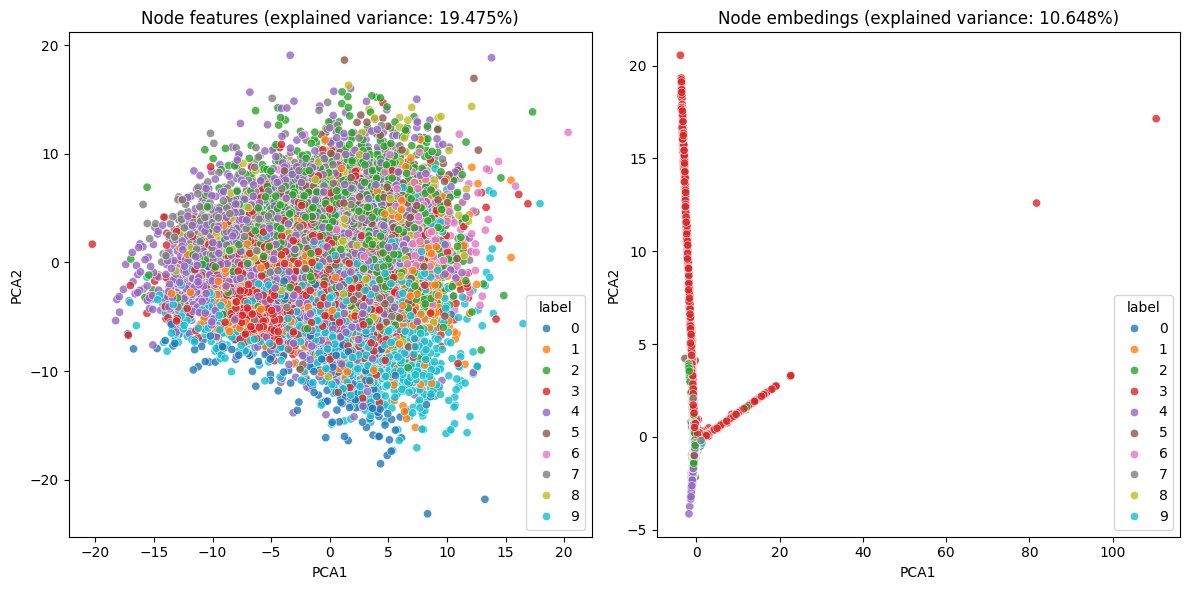

**node_embeddings_gca_gcn_256_1.0.pt**

| type       | ('train_acc', 'mean±std')   | ('test_acc', 'mean±std')   | ('train_auc', 'mean±std')   | ('test_auc', 'mean±std')   |
|:-----------|:----------------------------|:---------------------------|:----------------------------|:---------------------------|
| embeddings | 0.889 ± 0.013               | 0.76 ± 0.014               | 0.994 ± 0.001               | 0.94 ± 0.006               |
| features   | 1.0 ± 0.0                   | 0.705 ± 0.007              | 1.0 ± 0.0                   | 0.944 ± 0.003              |

In [35]:
gcn_results = []
for e in gcn_embeddings:
    df = load_execute(original_data, e)
    gcn_results.append(df)

In [63]:
def plot_metrics(train, test, labels, level, name):
    plt.plot(labels, train, marker='o', color='green', label='train')
    plt.plot(labels, test, marker='o', color='blue', label='test')
    plt.axhline(y=level, color='red', linestyle='--', label='features_test')
    plt.legend()
    plt.suptitle(name)
    plt.xticks(labels)
    plt.show()

In [64]:
gate_acc_test_means = [gate_results[i].groupby('type').mean()['test_acc']['embeddings'] for i in range(len(gate_results))]
gate_acc_train_means = [gate_results[i].groupby('type').mean()['train_acc']['embeddings'] for i in range(len(gate_results))]
gate_auc_test_means = [gate_results[i].groupby('type').mean()['test_auc']['embeddings'] for i in range(len(gate_results))]
gate_auc_train_means = [gate_results[i].groupby('type').mean()['train_auc']['embeddings'] for i in range(len(gate_results))]

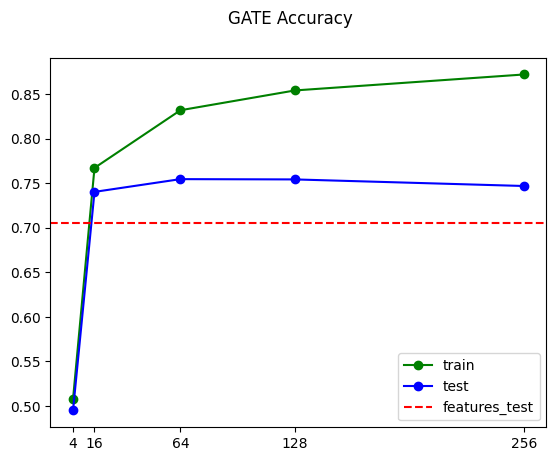

In [68]:
plot_metrics(gate_acc_train_means, gate_acc_test_means, dims, 0.705, 'GATE Accuracy')

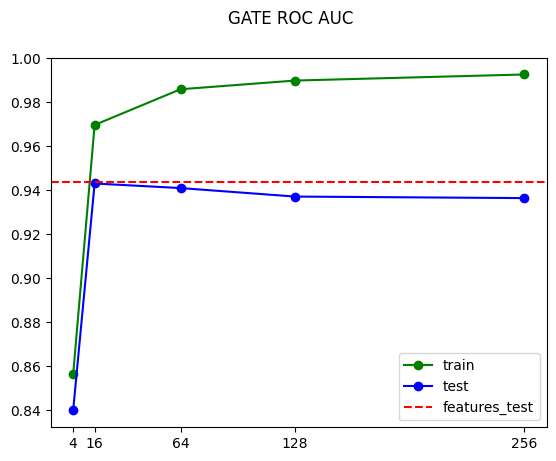

In [69]:
plot_metrics(gate_auc_train_means, gate_auc_test_means, dims, 0.944, 'GATE ROC AUC')

In [70]:
gcn_acc_test_means = [gcn_results[i].groupby('type').mean()['test_acc']['embeddings'] for i in range(len(gcn_results))]
gcn_acc_train_means = [gcn_results[i].groupby('type').mean()['train_acc']['embeddings'] for i in range(len(gcn_results))]
gcn_auc_test_means = [gcn_results[i].groupby('type').mean()['test_auc']['embeddings'] for i in range(len(gcn_results))]
gcn_auc_train_means = [gcn_results[i].groupby('type').mean()['train_auc']['embeddings'] for i in range(len(gcn_results))]

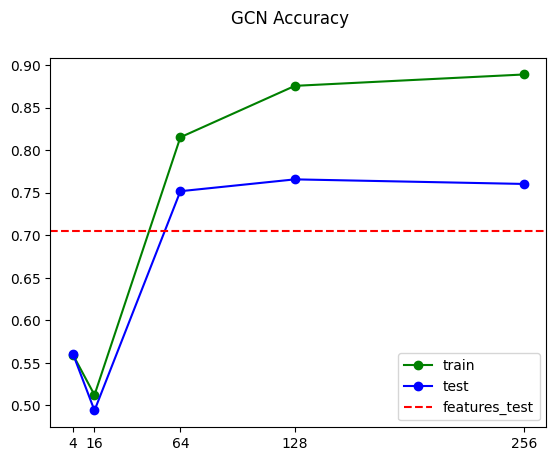

In [71]:
plot_metrics(gcn_acc_train_means, gcn_acc_test_means, dims, 0.705, 'GCN Accuracy')

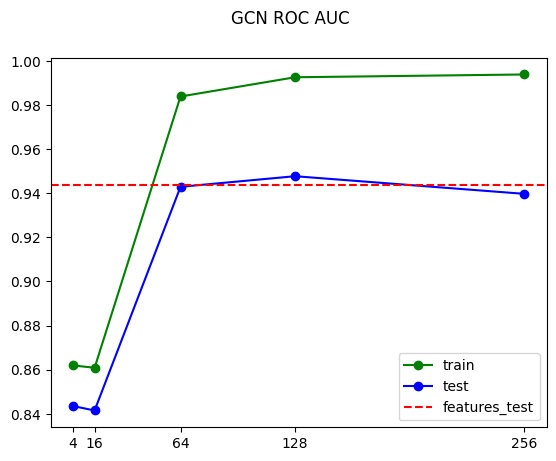

In [72]:
plot_metrics(gcn_auc_train_means, gcn_auc_test_means, dims, 0.944, 'GCN ROC AUC')

## Opis rezultatów
- na reprezentacji wyprodukowanej przez koder GCN osiągnięto większe accuracy
- osiągnięto maksymalne accuracy $0.766$, zatem mniej niż w pracy GCA $0.7835$, różnica może być spowodowana niezastosowaniem MLP w funkcji straty
- więcej wymiarowe reprezentacje dawały dużo lepsze wyniki w zadaniu klasyfikacji, ale w zadaniu klasteryzacji wyniki były bardzo zbliżone